In [1]:
from xai.policy import *
from torchvision.datasets.mnist import MNIST
import matplotlib.pyplot as plt

import torch
import random
import numpy as np

In [2]:
mnist = MNIST(".", download=True)
images = mnist.data.float()/255.0

labels = torch.zeros((mnist.data.shape[0],10)).float()
labels[torch.arange(0,mnist.data.shape[0]),mnist.targets] = 1.0

images.shape, labels.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 10]))

In [3]:
encoder = Policy.new((28,28),5, hidden_layers=2, activation="relu")
decoder = Policy.new(5,(28,28), hidden_layers=2, activation="relu")
autoencoder = encoder + decoder
autoencoder

/home/eivind/master-project/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Sequential(
  (0): Linear(in_features=784, out_features=524, bias=True)
  (1): ReLU()
  (2): Linear(in_features=524, out_features=264, bias=True)
  (3): ReLU()
  (4): Linear(in_features=264, out_features=5, bias=True)
  (5): Linear(in_features=5, out_features=264, bias=True)
  (6): ReLU()
  (7): Linear(in_features=264, out_features=524, bias=True)
  (8): ReLU()
  (9): Linear(in_features=524, out_features=784, bias=True)
)

In [14]:
autoencoder.adam().fit(
    X=images,
    Y=images,
    steps=10000,
    batch_size=64,
    loss_criterion="HuberLoss",
    verbose=True
)

Loss: 0.011613: 100%|██████████| 10000/10000 [02:27<00:00, 67.97it/s]


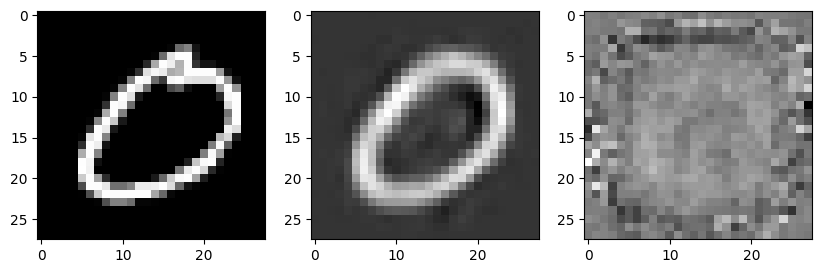

In [48]:
X = images[random.randint(0,len(images))]
feedforward = autoencoder(X)

Y = feedforward.numpy()

dY = feedforward.derivative(lambda t: t.sum(), order=1)

fig = plt.figure(figsize=(10,7)) 
fig.add_subplot(1,3,1)
plt.imshow(X, cmap="gray") 
fig.add_subplot(1,3,2)
plt.imshow(Y, cmap="gray") 
fig.add_subplot(1,3,3)
plt.imshow(dY, cmap="gray")